In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"veerendranadhvallepu","key":"1e9a7d808f93963b851766f7449509cf"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!kaggle datasets download andrewmvd/ocular-disease-recognition-odir5k

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other


In [5]:
!unzip /content/ocular-disease-recognition-odir5k.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import os

def get_file_list(directory):
  """
  Returns a list of all files in the given directory.
  """
  file_list = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      file_list.append(filename)
  return file_list

image_files1 = set(get_file_list('/content/ODIR-5K/ODIR-5K/Testing Images'))
image_files2 = set(get_file_list('/content/ODIR-5K/ODIR-5K/Training Images'))



In [8]:
import pandas as pd
df = pd.read_csv('/content/full_df.csv')

In [9]:
for index, row in df.iterrows():
  left_fundus = row['Left-Fundus']
  right_fundus = row['Right-Fundus']

  if left_fundus in image_files1:
    df.at[index, 'Left-Fundus'] = '/content/ODIR-5K/ODIR-5K/Testing Images/' + left_fundus
  elif left_fundus in image_files2:
    df.at[index, 'Left-Fundus'] = '/content/ODIR-5K/ODIR-5K/Training Images/' + left_fundus
  else:
    print(left_fundus)

  if right_fundus in image_files1:
    df.at[index, 'Right-Fundus'] = '/content/ODIR-5K/ODIR-5K/Testing Images/' + right_fundus
  elif right_fundus in image_files2:
    df.at[index, 'Right-Fundus'] = '/content/ODIR-5K/ODIR-5K/Training Images/' + right_fundus
  else:
    print(right_fundus)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shap

In [11]:
CFG = {
    'img_size': 224,
    'batch_size': 32,
    'num_classes': 8,  # N,D,G,C,A,H,M,O
    'metadata_size': 2, # Age (normalized), Sex (encoded)
    'lr': 1e-4,
    'epochs': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [12]:
class OcularDataset(Dataset):
    """Custom dataset handling both images and metadata"""

    def __init__(self, df, transform=None):
        """
        Args:
            df: DataFrame containing file paths and metadata
            transform: Optional image transformations
        """
        self.df = df
        self.transform = transform

        # Clean and normalize data
        self._preprocess_data()

    def _preprocess_data(self):
        """Handle missing values and normalize features"""
        # Age: Fill missing with median, normalize to 0-1
        self.df['Patient Age'] = self.df['Patient Age'].fillna(self.df['Patient Age'].median())
        self.df['age_norm'] = (self.df['Patient Age'].clip(0, 100) / 100).astype(np.float32)

        # Sex: Encode as 0 (Male), 1 (Female), 2 (Unknown)
        self.df['sex_encoded'] = self.df['Patient Sex'].map({'Male':0, 'Female':1}).fillna(2).astype(np.int64)

        # Targets
        self.target_cols = ['N','D','G','C','A','H','M','O']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Returns (left_img, right_img, metadata), targets"""
        row = self.df.iloc[idx]

        # Load images
        left_img = self._load_image(row['Left-Fundus'])
        right_img = self._load_image(row['Right-Fundus'])

        # Metadata: [age_norm, sex_encoded]
        metadata = torch.tensor([row['age_norm'], row['sex_encoded']], dtype=torch.float32)

        # Targets
        targets = torch.tensor(row[self.target_cols].values.astype(np.float32))

        return (left_img, right_img, metadata), targets

    def _load_image(self, path):
        """Load and transform single image"""
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [13]:
test_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'], CFG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
class OcularDiseaseModel(nn.Module):
    """Multi-modal model combining image and metadata features"""

    def __init__(self):
        super().__init__()

        # Image feature extractor (shared weights for both eyes)
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove final layers

        # Metadata processor
        self.meta_net = nn.Sequential(
            nn.Linear(CFG['metadata_size'], 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16))
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280*2 + 16, 512),  # EfficientNet features + metadata
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, CFG['num_classes']))

    def forward(self, left_img, right_img, metadata):
        # Extract image features
        left_features = self._get_image_features(left_img)
        right_features = self._get_image_features(right_img)

        # Process metadata
        meta_features = self.meta_net(metadata)

        # Combine features
        combined = torch.cat([left_features, right_features, meta_features], dim=1)
        return self.classifier(combined)

    def _get_image_features(self, x):
        """Extract features from single image"""
        features = self.cnn.features(x)
        return nn.functional.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)


In [15]:
val_ds=OcularDataset(df, transform=test_transform)

In [16]:
# prompt: load the model '/content/drive/MyDrive/saved_models/best_model.pth'

device = torch.device(CFG['device'])
model = OcularDiseaseModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/saved_models/best_model.pth', map_location=device))
model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 95.5MB/s]


OcularDiseaseModel(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [17]:
df1=df.sample(frac=0.2)
v_ds=OcularDataset(df1, transform=test_transform)

In [ ]:
# prompt: predict all the labels in val_ds

val_loader = DataLoader(v_ds, batch_size=CFG['batch_size'], shuffle=False)
N_p=[]
D_p=[]
G_p=[]
C_p=[]
A_p=[]
H_p=[]
M_p=[]
O_p=[]
N_t=[]
D_t=[]
G_t=[]
C_t=[]
A_t=[]
H_t=[]
M_t=[]
O_t=[]
with torch.no_grad():
    model.eval()
    for (left_img, right_img, metadata), targets in val_loader:
        left_img, right_img, metadata = left_img.to(device), right_img.to(device), metadata.to(device)
        outputs = model(left_img, right_img, metadata)
        predictions = torch.sigmoid(outputs).cpu().numpy()
        predictions = np.round(predictions)
        targets = targets.cpu().numpy()
        N_p.extend(predictions[:, 0])
        D_p.extend(predictions[:, 1])
        G_p.extend(predictions[:, 2])
        C_p.extend(predictions[:, 3])
        A_p.extend(predictions[:, 4])
        H_p.extend(predictions[:, 5])
        M_p.extend(predictions[:, 6])
        O_p.extend(predictions[:, 7])
        N_t.extend(targets[:, 0])
        D_t.extend(targets[:, 1])
        G_t.extend(targets[:, 2])
        C_t.extend(targets[:, 3])
        A_t.extend(targets[:, 4])
        H_t.extend(targets[:, 5])
        M_t.extend(targets[:, 6])
        O_t.extend(targets[:, 7])

Confusion Matrix for Normal (N):
[[818  40]
 [ 83 337]]
Accuracy: 90.3756, F1-score: 0.8457, Recall: 0.8024, Precision: 0.8939


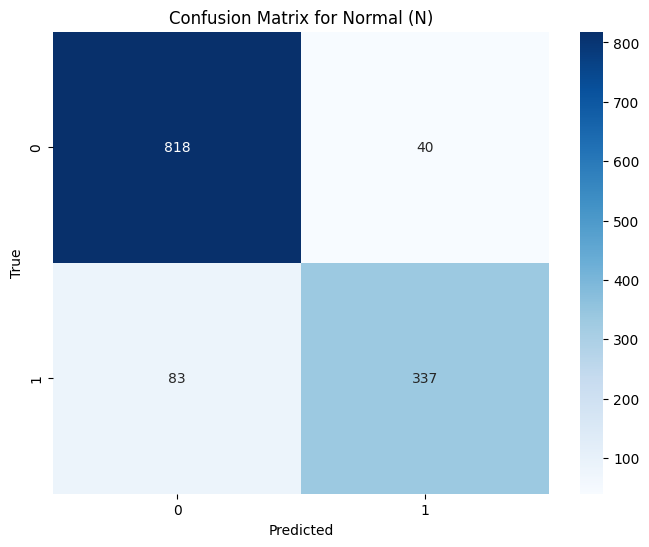

Confusion Matrix for Diabetes (D):
[[843  31]
 [145 259]]
Accuracy: 86.2285, F1-score: 0.7464, Recall: 0.6411, Precision: 0.8931


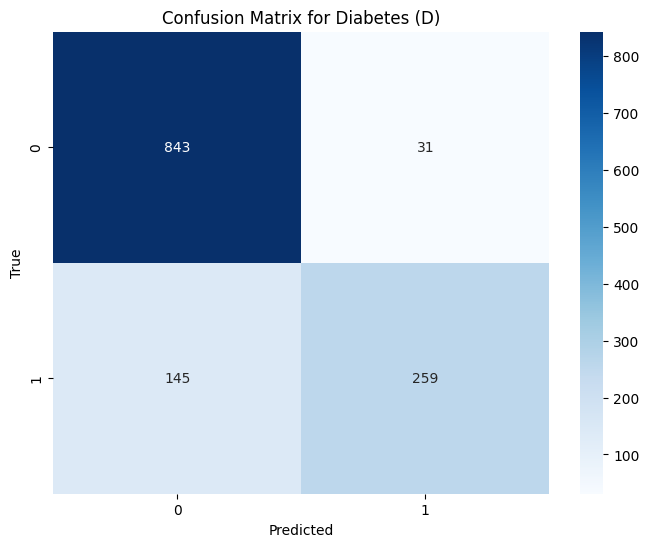

Confusion Matrix for Glaucoma (G):
[[1198    8]
 [  17   55]]
Accuracy: 98.0438, F1-score: 0.8148, Recall: 0.7639, Precision: 0.8730


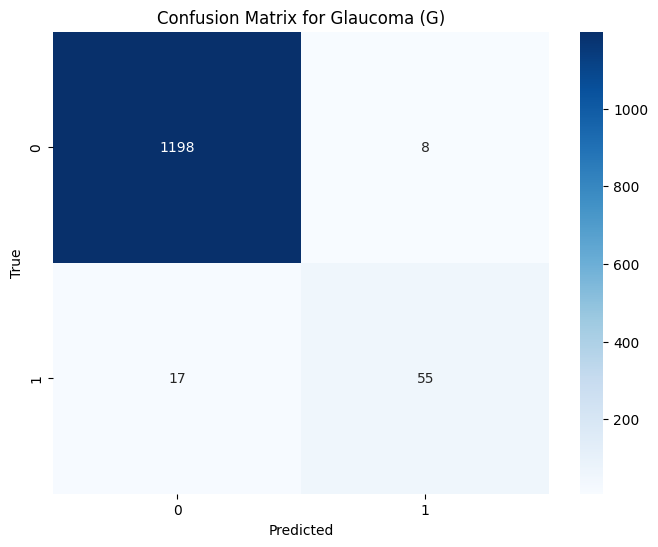

Confusion Matrix for Cataract (C):
[[1196    3]
 [   6   73]]
Accuracy: 99.2958, F1-score: 0.9419, Recall: 0.9241, Precision: 0.9605


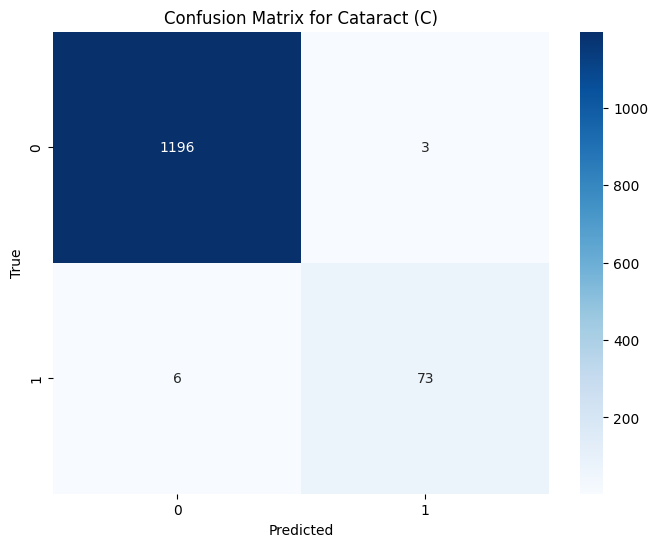

Confusion Matrix for Age related Macular Degeneration (A):
[[1197   14]
 [  17   50]]
Accuracy: 97.5743, F1-score: 0.7634, Recall: 0.7463, Precision: 0.7812


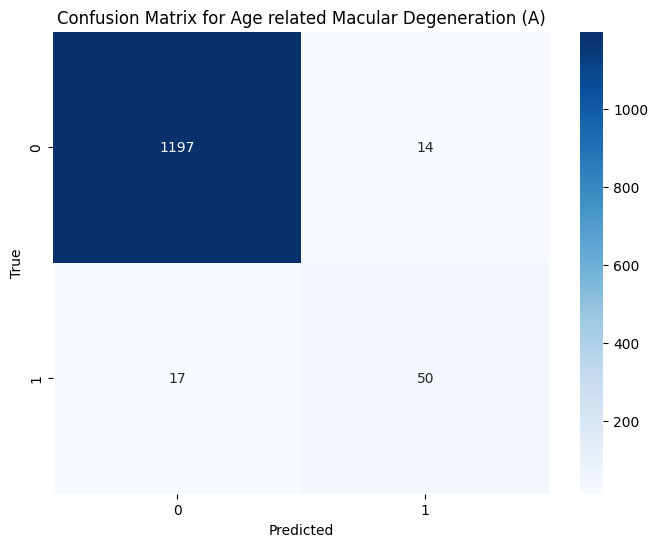

Confusion Matrix for Hypertension (H):
[[1239    0]
 [  39    0]]
Accuracy: 96.9484, F1-score: 0.0000, Recall: 0.0000, Precision: nan


<ipython-input-19-e6d4da251868>:17: RuntimeWarning: invalid value encountered in scalar divide
  precision=cm[1,1]/(cm[1,1]+cm[0,1])


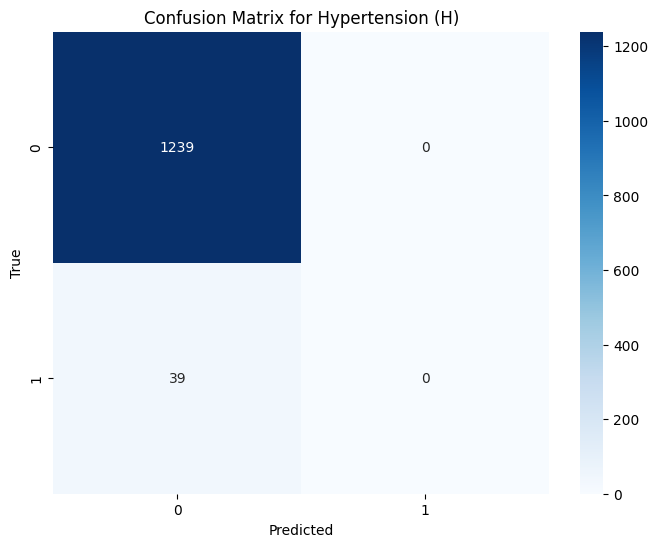

Confusion Matrix for Pathological Myopia (M):
[[1212    1]
 [   6   59]]
Accuracy: 99.4523, F1-score: 0.9440, Recall: 0.9077, Precision: 0.9833


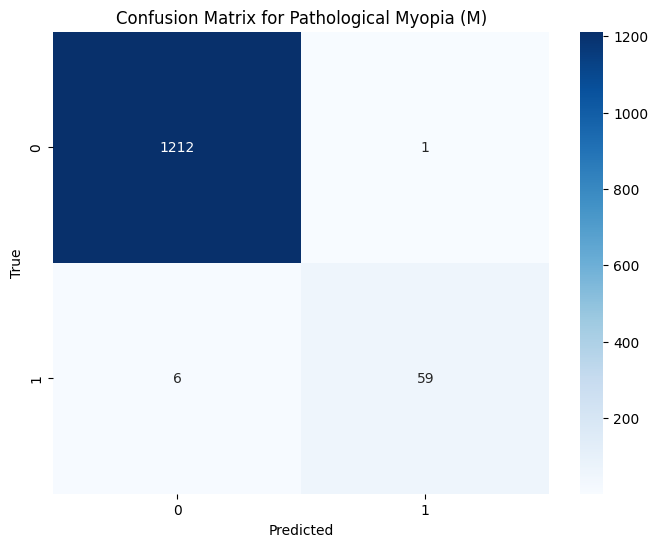

Confusion Matrix for Other diseases/abnormalities (O):
[[828 132]
 [ 85 233]]
Accuracy: 83.0203, F1-score: 0.6823, Recall: 0.7327, Precision: 0.6384


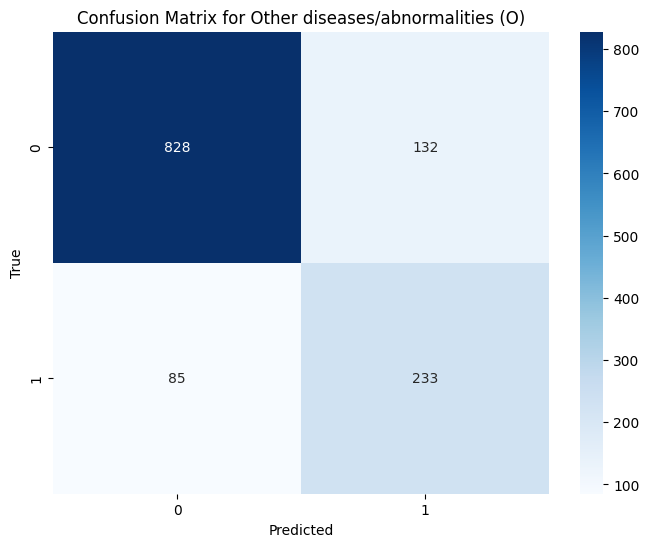

In [ ]:
# prompt: show confusion matrix  and acc,f1

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Assuming N_p, D_p, ... O_t are defined as in your code

targets = [N_t, D_t, G_t, C_t, A_t, H_t, M_t, O_t]
predictions = [N_p, D_p, G_p, C_p, A_p, H_p, M_p, O_p]
target_names = ['Normal (N)', 'Diabetes (D)', 'Glaucoma (G)', 'Cataract (C)', 'Age related Macular Degeneration (A)', 'Hypertension (H)', 'Pathological Myopia (M)', 'Other diseases/abnormalities (O)']
accuracy_score_list={}
for i in range(len(targets)):
    cm = confusion_matrix(targets[i], predictions[i])
    acc = accuracy_score(targets[i], predictions[i])*100
    f1 = f1_score(targets[i], predictions[i])
    recall=cm[1,1]/(cm[1,1]+cm[1,0])
    precision=cm[1,1]/(cm[1,1]+cm[0,1])
    print(f'Confusion Matrix for {target_names[i]}:')
    print(cm)
    print(f'Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix for {target_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    accuracy_score_list[target_names[i]]=acc



In [ ]:
from sklearn.metrics import f1_score, hamming_loss, precision_score

# Assuming targets and predictions are defined as in your code
targets = [N_t, D_t, G_t, C_t, A_t, H_t, M_t, O_t]
predictions = [N_p, D_p, G_p, C_p, A_p, H_p, M_p, O_p]

# Calculate micro and macro F1-score
micro_f1 = f1_score(np.array(targets).transpose(), np.array(predictions).transpose(), average='micro')
macro_f1 = f1_score(np.array(targets).transpose(), np.array(predictions).transpose(), average='macro')

print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Calculate Hamming Loss
hamming = hamming_loss(np.array(targets).transpose(), np.array(predictions).transpose())
print(f"Hamming Loss: {hamming:.4f}")

# Calculate average precision
average_precision = precision_score(np.array(targets).transpose(), np.array(predictions).transpose(), average='macro')
print(f"Average Precision: {average_precision:.4f}")


Micro F1-score: 0.7727
Macro F1-score: 0.7173
Hamming Loss: 0.0613
Average Precision: 0.7529


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


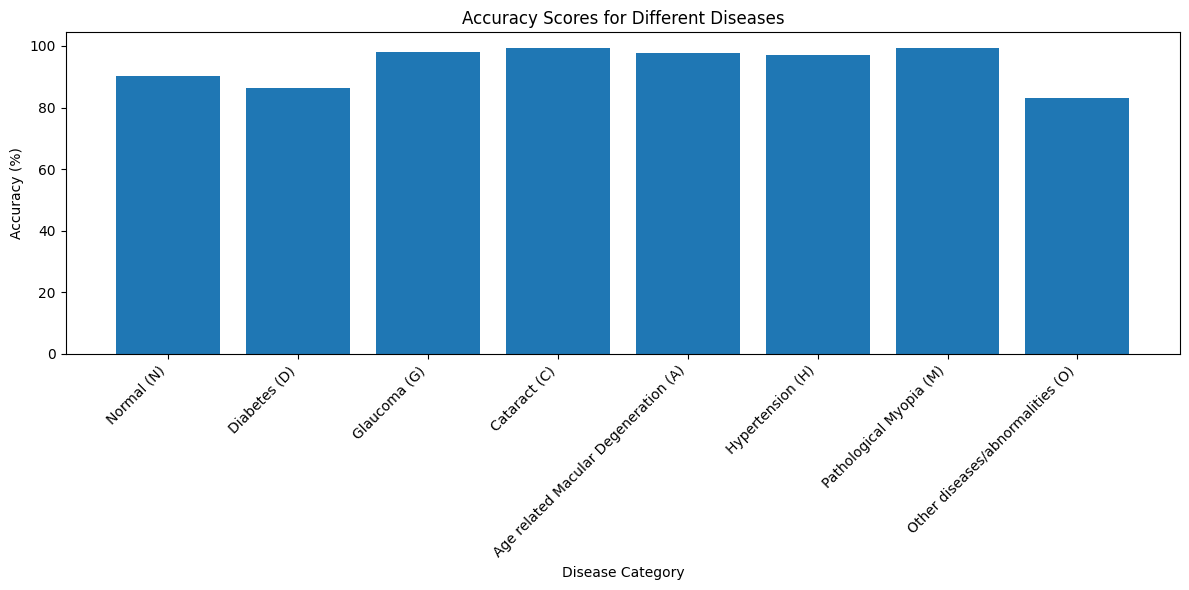

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(accuracy_score_list.keys(), accuracy_score_list.values())
plt.xlabel("Disease Category")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Scores for Different Diseases")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


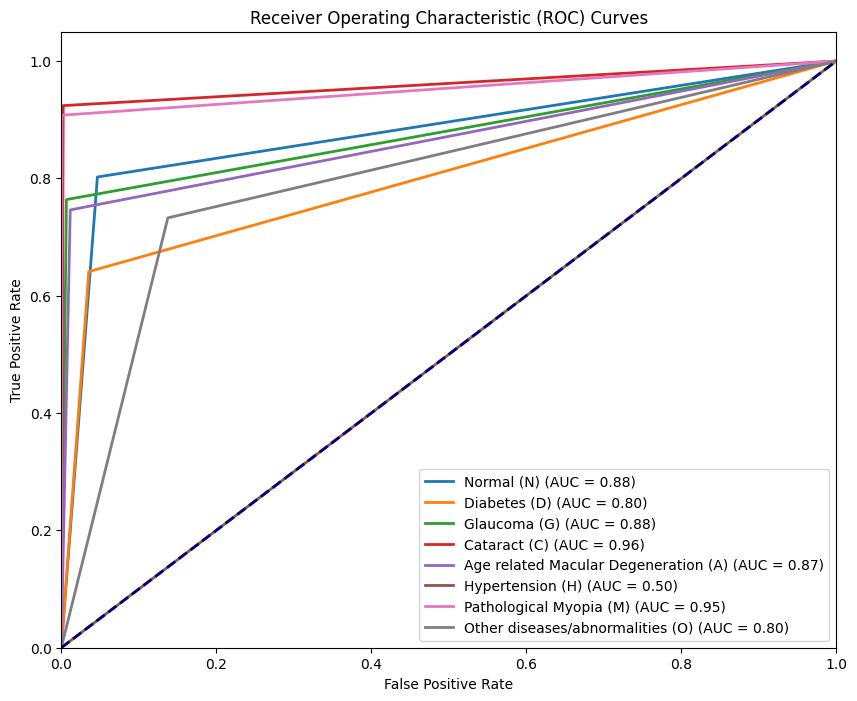

In [ ]:
from sklearn.metrics import roc_curve, auc
targets = [N_t, D_t, G_t, C_t, A_t, H_t, M_t, O_t]
predictions = [N_p, D_p, G_p, C_p, A_p, H_p, M_p, O_p]
target_names = ['Normal (N)', 'Diabetes (D)', 'Glaucoma (G)', 'Cataract (C)', 'Age related Macular Degeneration (A)', 'Hypertension (H)', 'Pathological Myopia (M)', 'Other diseases/abnormalities (O)']

plt.figure(figsize=(10, 8))  # Adjust figure size as needed

for i in range(len(targets)):
    fpr, tpr, thresholds = roc_curve(targets[i], predictions[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [18]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [19]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
def get_grad_cam(l_img,r_img,metadata):
  # Load Grad-CAM
  cam_extractor = GradCAM(model.cnn, target_layer="features.8")  # for EfficientNet B0
  class_predict=[]
  get_class=['Normal (N)', 'Diabetes (D)', 'Glaucoma (G)', 'Cataract (C)', 'Age related Macular Degeneration (A)', 'Hypertension (H)', 'Pathological Myopia (M)', 'Other diseases/abnormalities (O)']
  output = model(l_img, r_img, metadata)
  pred_class = torch.argmax(output[0]).item()
  predictions = torch.sigmoid(outputs)
  predictions = predictions.cpu().numpy()[0]
  predictions = [round(p) for p in predictions]
  for i in range(len(predictions)):
    if predictions[i]==1:
      class_predict.append(get_class[i])

  # Extract CAM
  activation_map1 = cam_extractor(pred_class, model.cnn.features(l_img))[0].cpu()
  result1 = overlay_mask(to_pil_image(l_img.squeeze(0).cpu()), to_pil_image(activation_map1, mode='F'), alpha=0.5)
  activation_map2 = cam_extractor(pred_class, model.cnn.features(r_img))[0].cpu()
  result2 = overlay_mask(to_pil_image(r_img.squeeze(0).cpu()), to_pil_image(activation_map2, mode='F'), alpha=0.5)
  # Show CAM
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))
  fig.suptitle(f"Prediction: {class_predict}")
  axes[0].imshow(result1, cmap='viridis')
  axes[0].set_title("Grad-CAM on Left Eye")
  axes[0].axis('off')

  im=axes[1].imshow(result2, cmap='viridis')
  axes[1].set_title("Grad-CAM on Right Eye")
  axes[1].axis('off')
  # Add colorbar
  fig.colorbar(im, ax=axes.ravel().tolist(), label='Activation Intensity', location='right', shrink=0.8)
  plt.tight_layout(rect=[0, 0, 0.795, 1])
  plt.show()

Predictions: [1, 0, 0, 0, 0, 0, 0, 0]
Actual Targets: [np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]


<ipython-input-19-5f722212e3ce>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.795, 1])


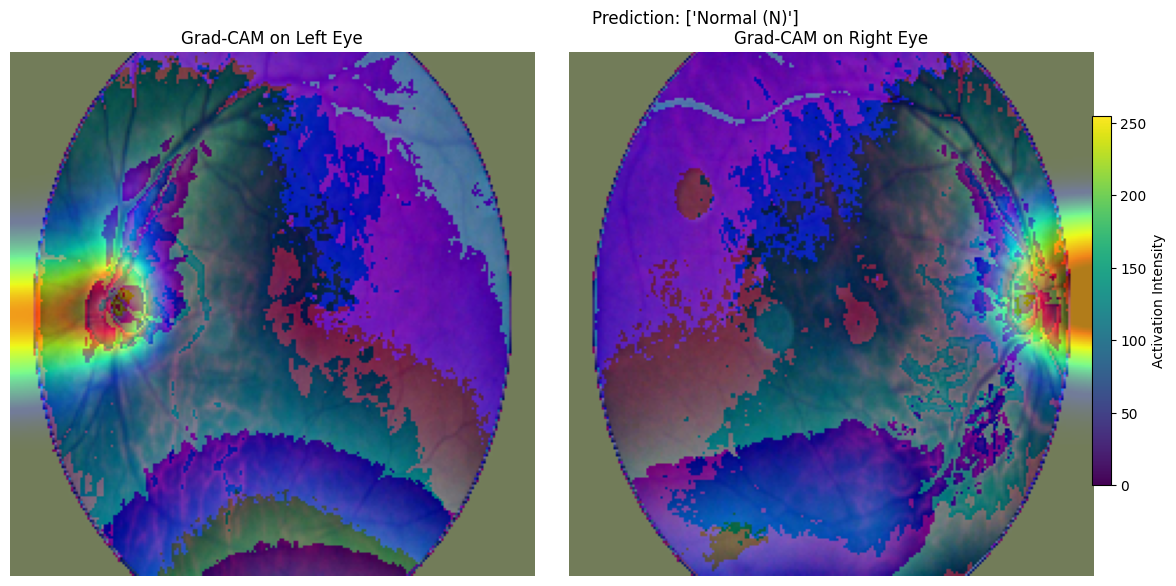

In [20]:
import random
import torch

# Assuming val_ds and model are defined as in the provided code

# Choose a random sample from the validation dataset
random_index = random.randint(0, len(val_ds) - 1)
(left_img, right_img, metadata), targets = val_ds[random_index]

# Move data to the appropriate device
left_img, right_img, metadata, targets = [t.to(CFG['device']) for t in [left_img.unsqueeze(0), right_img.unsqueeze(0), metadata.unsqueeze(0), targets.unsqueeze(0)]]


# Perform prediction
with torch.no_grad():
  model.eval()
  outputs = model(left_img, right_img, metadata)
  predictions = torch.sigmoid(outputs)
  predictions = predictions.cpu().numpy()[0]
  predictions = [round(p) for p in predictions]
  targets = targets.cpu().numpy()[0]

print("Predictions:", list(predictions))
print("Actual Targets:", list(targets))
get_grad_cam(left_img,right_img, metadata)

<ipython-input-19-5f722212e3ce>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.795, 1])


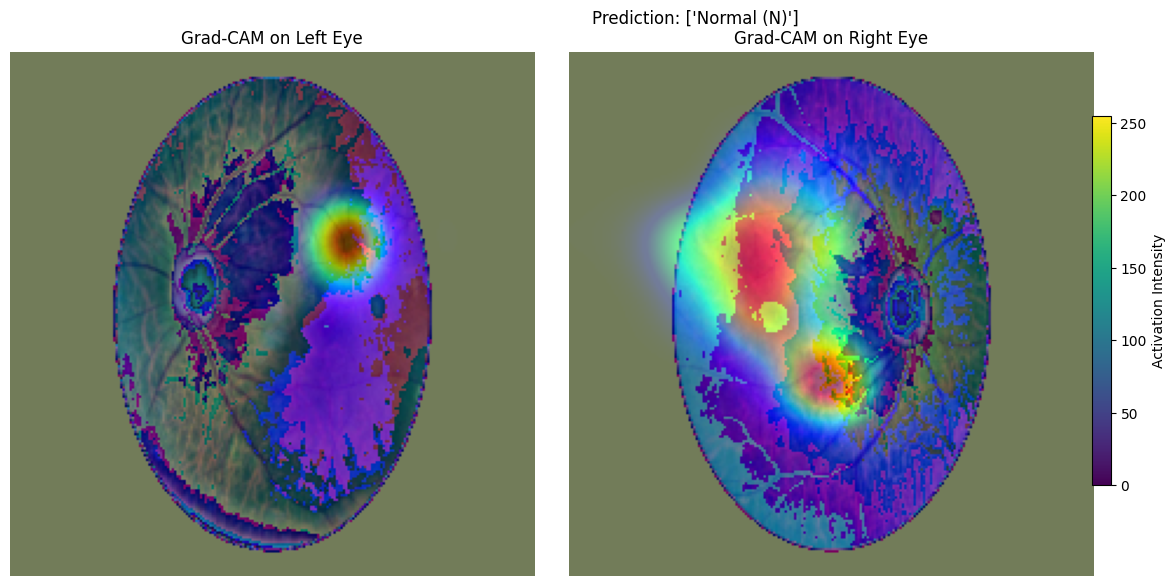

In [21]:
(left_img, right_img, metadata), targets = val_ds[78]

# Move data to the appropriate device
left_img, right_img, metadata, targets = [t.to(CFG['device']) for t in [left_img.unsqueeze(0), right_img.unsqueeze(0), metadata.unsqueeze(0), targets.unsqueeze(0)]]
get_grad_cam(left_img,right_img, metadata)